<h1 id="import" style="color:white;background:#191970;padding:10px;border-radius:10px"><img src="https://user-images.githubusercontent.com/88631980/236693041-badeab36-8da4-4c1b-8171-4de19da3455a.png" alt="BTK Akademi Logo" width="60"/> DATATHON 2023</h1>

<a id='top'></a>
## <b>1.0 <span style='color:#80055D'>|</span> İçindekiler</b>

* [**1. EDA**](#1)
    * [1.1. Sürekli Değişkenler](#1.1)    
    * [1.2. Kesikli Değişkenler](#1.2)    
    * [1.3. Sınıf Dağılımları ve Betimsel İstatistikler](#1.3)    
    * [1.4. Kutu Grafiği ve Aykırı Değer Gözlemi](#1.4)
    * [1.5. Değişkenlik Katsayısı](#1.5)
    * [1.6. Scatter Plotlar](#1.6)
    * [1.7. Korelasyon](#1.7)
    
* [**2. VERİ ÖN İŞLEME**](#2)
    * [2.1. Aykrı Değerler](#2.1)    
    * [2.2. Kategori Gruplama](#2.2)    
    * [2.3. Yeni Feature Ekleme](#2.3)    
    * [2.4. Standartlaştırma ve Bağımlı-Bağımsız Değişken Ayrımı](#2.4)
    
* [**3. MODELLER**](#3)
    * [3.1. Varsayılan Parametreler ile Deneme ve Model Seçimi](#3.1)
    * [3.2. Hiperparametre Tuning](#3.2)
    * [3.3. En İyi Parametrelerle Tekrar Fit Et ve submission.csv dosyasını yaz](#3.3)

In [1]:
# gerekli kutuphaneler
import warnings 
import numpy as np  
import pandas as pd  
import seaborn as sns  
import plotly.express as px
import plotly.subplots as sp
from tabulate import tabulate
import plotly.graph_objs as go
import matplotlib.pyplot as plt 
warnings.filterwarnings('ignore')
from plotly.subplots import make_subplots

# models
import optuna
import catboost as cb
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC
import category_encoders as ce
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [2]:
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test_x.csv', index_col=0)
df = train.copy()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5460 entries, 0 to 5459
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Cinsiyet                                    5460 non-null   object 
 1   Yaş Grubu                                   5460 non-null   object 
 2   Medeni Durum                                5460 non-null   object 
 3   Eğitim Düzeyi                               5460 non-null   object 
 4   İstihdam Durumu                             5460 non-null   object 
 5   Yıllık Ortalama Gelir                       5460 non-null   float64
 6   Yaşadığı Şehir                              5460 non-null   object 
 7   En Çok İlgilendiği Ürün Grubu               5460 non-null   object 
 8   Yıllık Ortalama Satın Alım Miktarı          5460 non-null   float64
 9   Yıllık Ortalama Sipariş Verilen Ürün Adedi  5460 non-null   float64
 10  Eğitime Deva

In [4]:
# eksik degerler
df.isnull().sum().sum()

0

In [5]:
# tekrarlı degerler
df.duplicated().sum()

0

<a id="1"></a>
<h1 id="import" style="color:white;background:#191970;padding:8px;border-radius:8px"><img src="https://user-images.githubusercontent.com/88631980/236693041-badeab36-8da4-4c1b-8171-4de19da3455a.png" alt="BTK Akademi Logo" width="45"/> EDA 🔎 </h1>

<a id="1.1"></a>
## <b>1.1 <span style='color:#80055D'>|</span>Sürekli Değişkenler</b>

Dağılımların oldukça çarpık, birden fazla tepeli ve aykırılıklar içerdiği gözlemlenebiliyor.

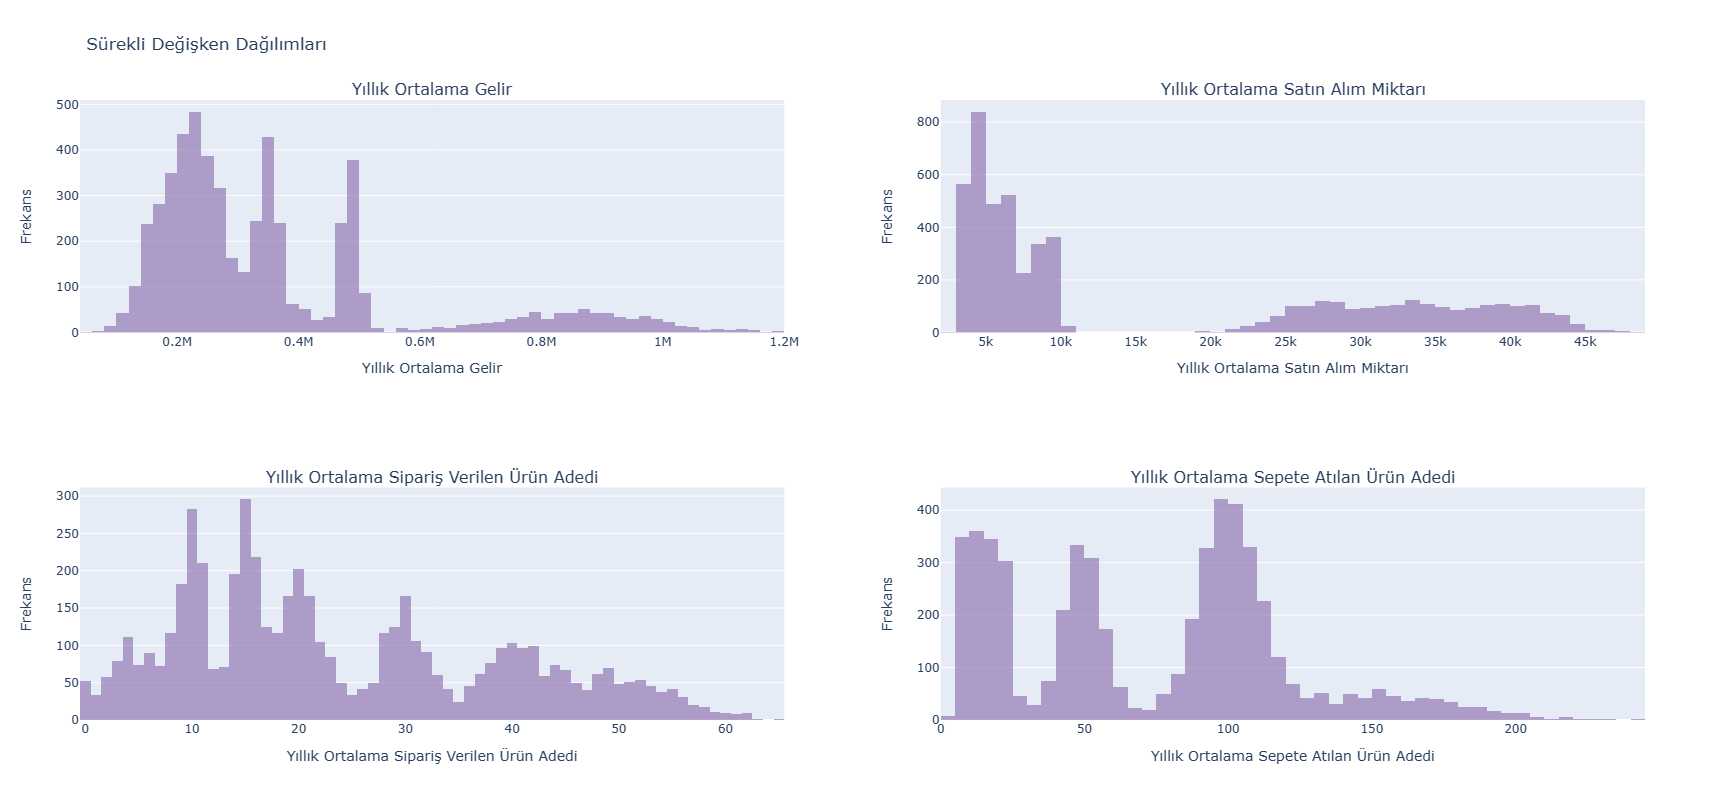

In [6]:
surekli_degiskenler = ['Yıllık Ortalama Gelir', 'Yıllık Ortalama Satın Alım Miktarı', 'Yıllık Ortalama Sipariş Verilen Ürün Adedi', 'Yıllık Ortalama Sepete Atılan Ürün Adedi']

fig = sp.make_subplots(rows=2, cols=2, subplot_titles=surekli_degiskenler)

for index, column in enumerate(surekli_degiskenler):
    row = index // 2 + 1
    col = index % 2 + 1
    trace = go.Histogram(x=df[column], marker_color='#967bb6', opacity=0.7)
    fig.add_trace(trace, row=row, col=col)
    fig.update_xaxes(title_text=column, row=row, col=col)
    fig.update_yaxes(title_text='Frekans', row=row, col=col)

fig.update_layout(height=800, width=1000, title_text='Sürekli Değişken Dağılımları', showlegend=False)
fig.show()

<a id="1.2"></a>
## <b>1.2 <span style='color:#80055D'>|</span>Kesikli Değişkenler</b>

Genel olarak sınıflar arasında aşırı bir dengesizlik mevcut değil, özellikle hedef değişken oldukça dengeli dağılım göstermiş.

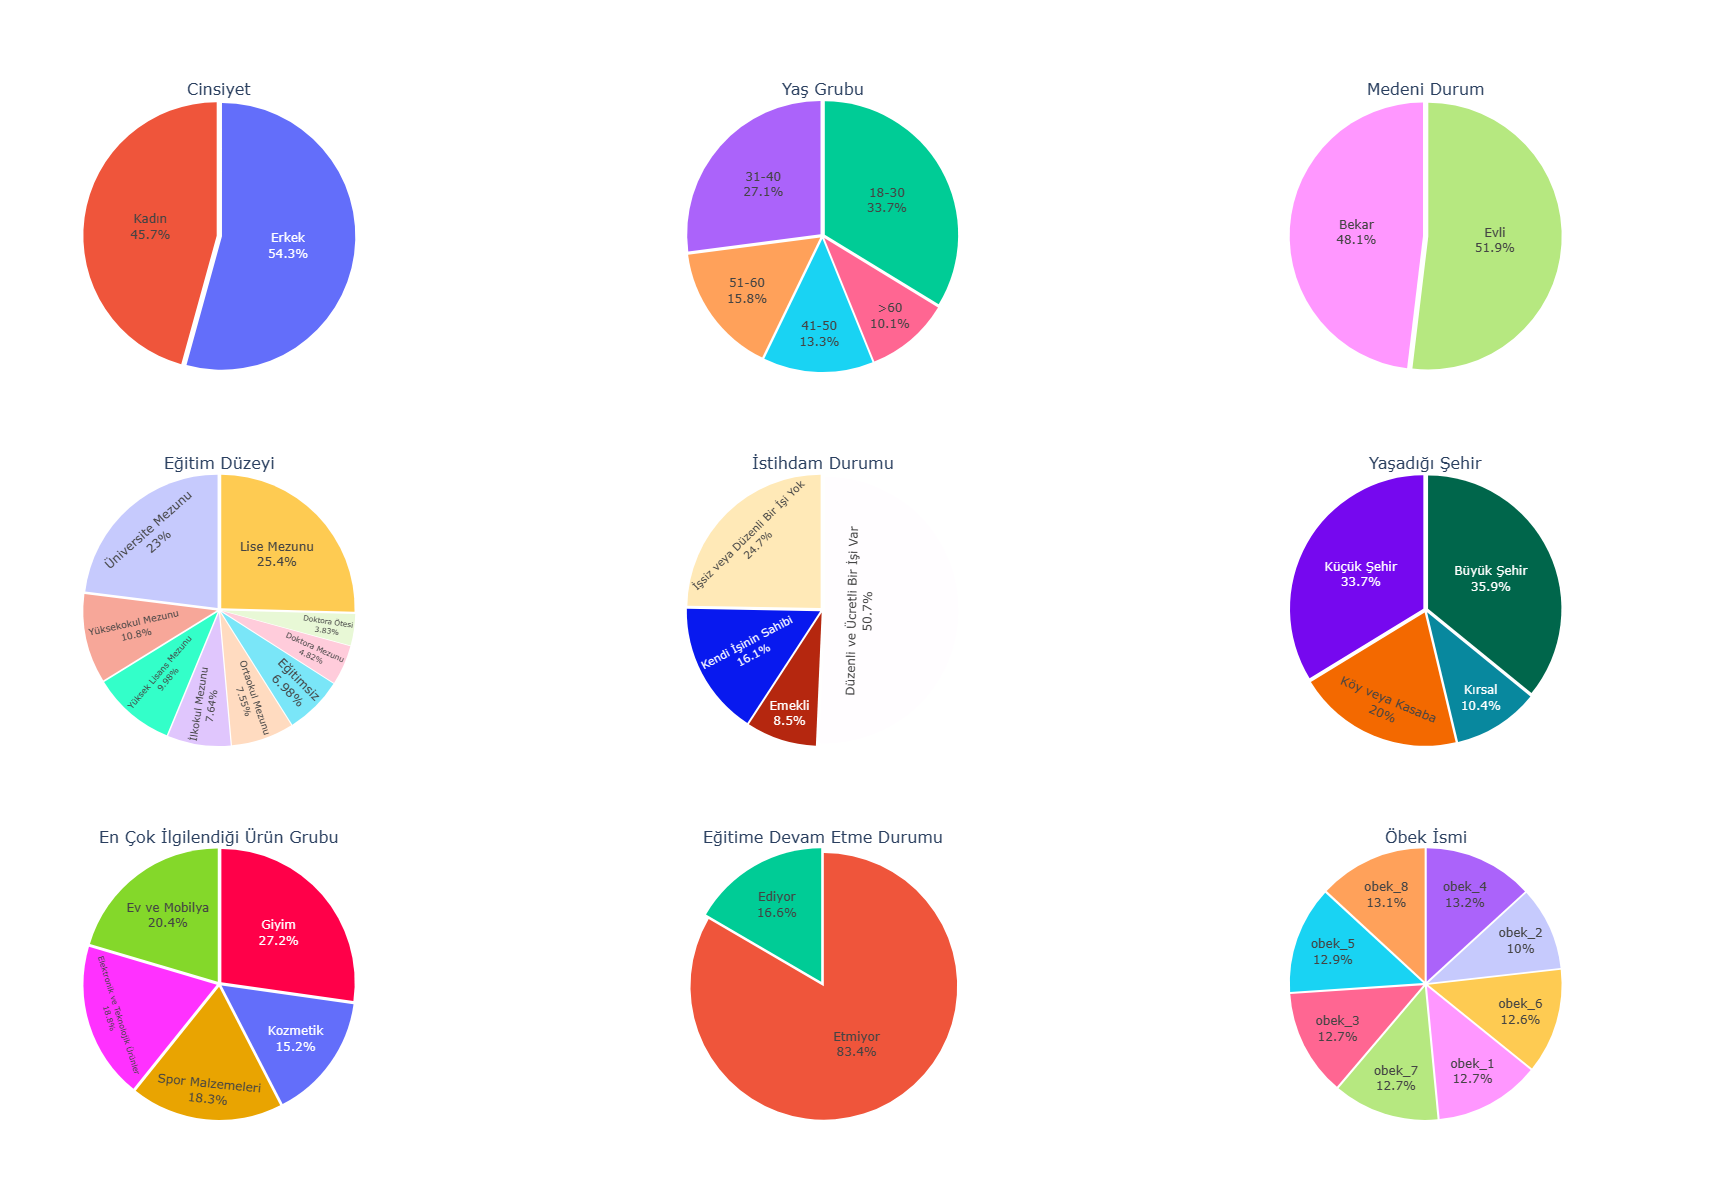

In [7]:
kesikli_degiskenler = ['Cinsiyet', 'Yaş Grubu', 'Medeni Durum', 'Eğitim Düzeyi', 'İstihdam Durumu', 'Yaşadığı Şehir', 'En Çok İlgilendiği Ürün Grubu', 'Eğitime Devam Etme Durumu', 'Öbek İsmi']

num_rows = len(kesikli_degiskenler) // 3 + (len(kesikli_degiskenler) % 3 > 0)
fig = make_subplots(rows=num_rows, cols=3, subplot_titles=kesikli_degiskenler, specs=[[{'type':'pie'}]*3]*num_rows, horizontal_spacing=0.1, vertical_spacing=0.1)

for index, degisken in enumerate(kesikli_degiskenler, 1):
    
    pie_trace = go.Pie(labels=df[degisken].value_counts().index, values=df[degisken].value_counts(), 
                       marker=dict(colors=sns.color_palette('pastel')), pull=0.02, textinfo='label+percent', textposition='inside')
    
    row = (index - 1) // 3 + 1
    col = (index - 1) % 3 + 1
    
    fig.add_trace(pie_trace, row=row, col=col)

fig.update_layout(height=num_rows * 400, width=1100, showlegend=False, margin=dict(l=0))
fig.show()

<a id="1.3"></a>
## <b>1.3 <span style='color:#80055D'>|</span>Sınıf Dağılımları ve Betimsel İstatistikler</b>

Yıllık ortalama gelir ve satın alımda standart sapmalar oldukça yüksek, özellikle %75'lik dilimle birlikte ortalamadan epeyce uzaklaşıyor değerler.

In [8]:
table_html = "<table>"
table_html += "<tr>"

for column in kesikli_degiskenler:
    unique_values = df[column].unique()
    value_counts = df[column].value_counts().reset_index()
    value_counts.columns = ['Value', 'Count']
    table = tabulate(value_counts, headers='keys', tablefmt='html', showindex=False)
    table_html += f"<td style='margin-right:20px;'><h4>{column}</h4>{table}</td>"
    
table_html += "</tr>"

table_html += "</table>"

from IPython.display import HTML
HTML(table_html)

In [9]:
df.describe().T.style.background_gradient(cmap = "plasma")

<a id="1.4"></a>
## <b>1.4 <span style='color:#80055D'>|</span>Kutu Grafiği ve Aykırı Değer Gözlemi</b>

Dağılımların çarpıklıkları bir yana yıllık ortalama gelirde çiddi aykırıklar bulunuyor gibi duruyor. Modelin genelleme yeteneği için bu sorunu çözmek iyi olacaktır.

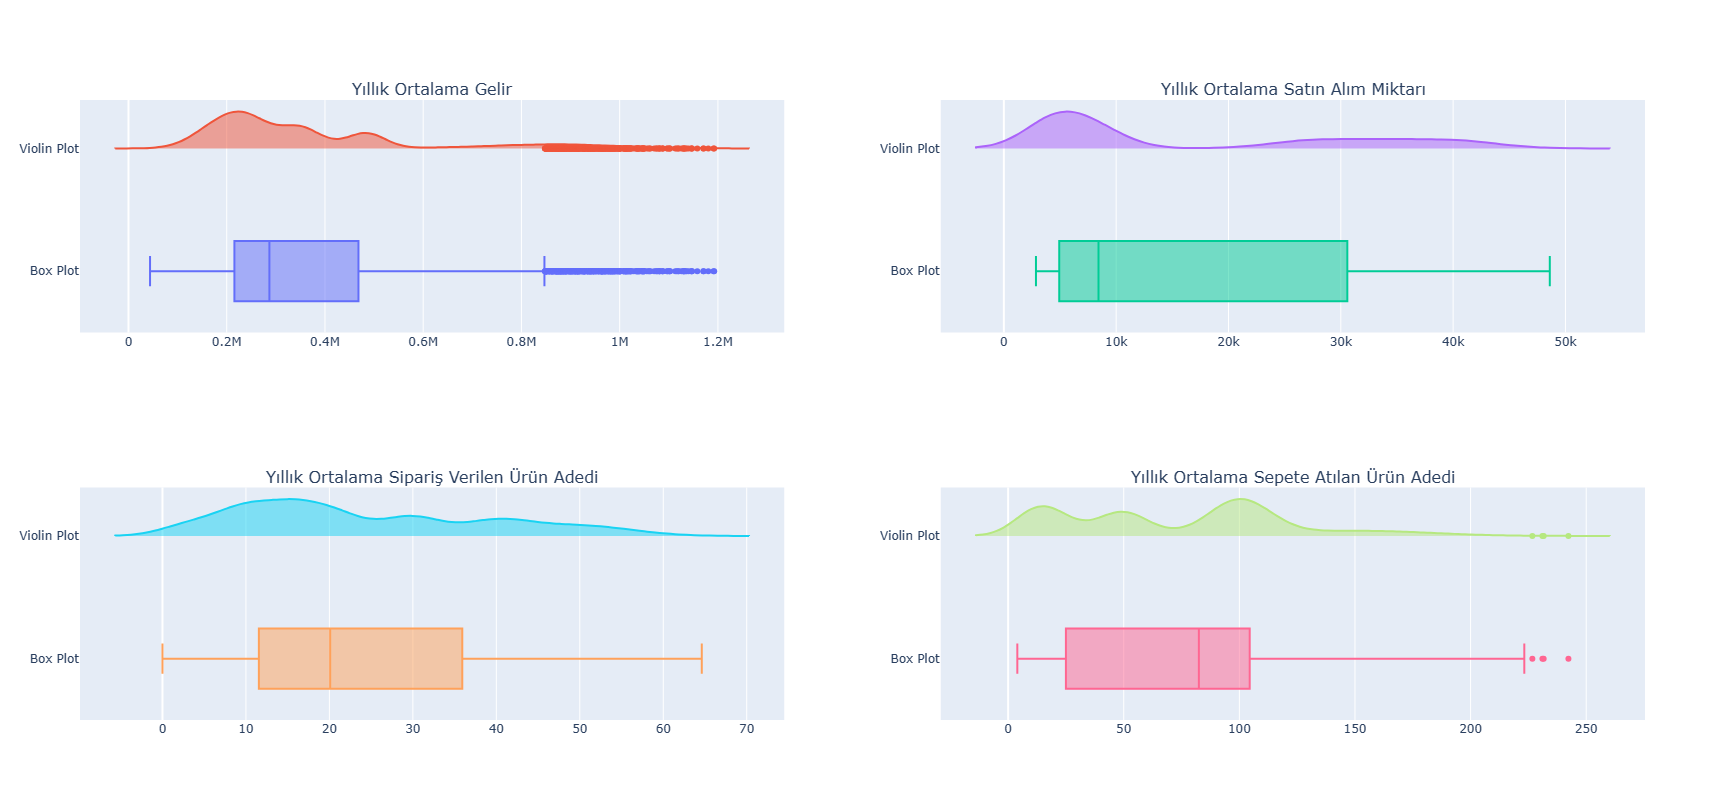

In [10]:
fig = make_subplots(rows=2, cols=2, subplot_titles=surekli_degiskenler)

for i, degisken in enumerate(surekli_degiskenler):
    box_trace = go.Box(x=df[degisken], name='Box Plot')
    violin_trace = go.Violin(x=df[degisken], name='Violin Plot', side='positive', width=0.6)
    row = (i // 2) + 1
    col = (i % 2) + 1
    fig.add_trace(box_trace, row=row, col=col)
    fig.add_trace(violin_trace, row=row, col=col)

fig.update_layout(showlegend=False)
fig.update_layout(height=800, width=1200)
fig.show()

<a id="1.5"></a>
## <b>1.5 <span style='color:#80055D'>|</span>Değişkenlik Katsayısı</b>

Varyasyonu incelediğimizde yıllık ortalama satın alımda öbekten öbeğe yüksek bir varyasyon olduğu anlaşılıyor. Diğer değişkenler benzer değerler almış.

In [11]:
degiskenlik_katsayisi = df.std() / df.mean()
print(degiskenlik_katsayisi*100)

Yıllık Ortalama Gelir                         60.432312
Yıllık Ortalama Satın Alım Miktarı            84.849857
Yıllık Ortalama Sipariş Verilen Ürün Adedi    62.167659
Yıllık Ortalama Sepete Atılan Ürün Adedi      64.284483
dtype: float64


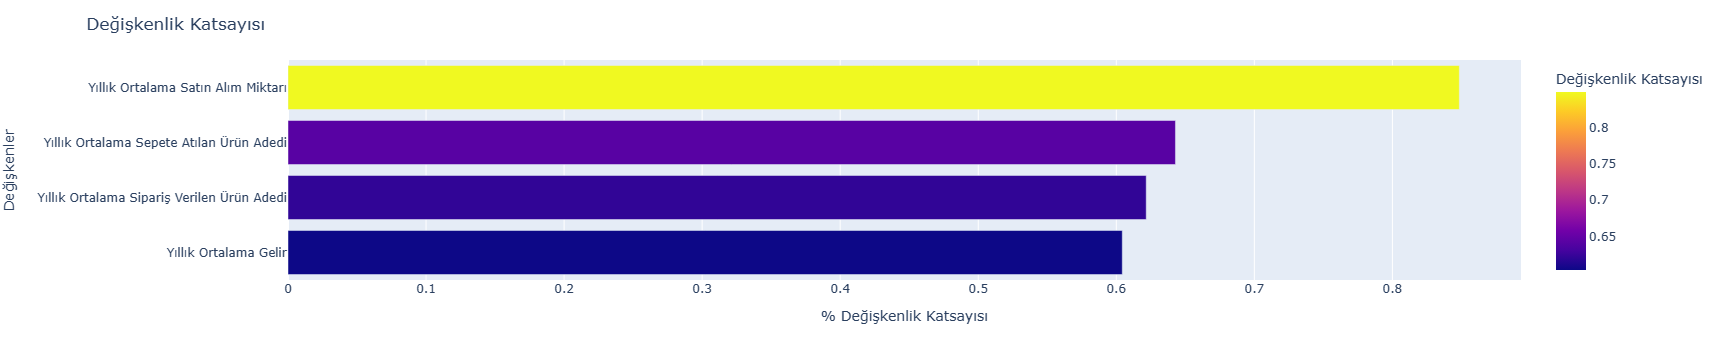

In [12]:
df_degiskenlik = pd.DataFrame({'Değişkenler': degiskenlik_katsayisi.index, 'Değişkenlik Katsayısı': degiskenlik_katsayisi.values})
sirali_df = df_degiskenlik.sort_values(by='Değişkenlik Katsayısı')
fig = px.bar(sirali_df, x='Değişkenlik Katsayısı', y='Değişkenler', orientation='h', color='Değişkenlik Katsayısı')
fig.update_layout(title='Değişkenlik Katsayısı', xaxis_title='% Değişkenlik Katsayısı', yaxis_title='Değişkenler')
fig.show()

<a id="1.6"></a>
## <b>1.6 <span style='color:#80055D'>|</span>Scatter Plotlar</b>

Her özelliğin birbirleri üzerindeki kırılımları incelenmiş ve scatter plotlardan çıkarılan sonuçlardan oluşturulan tablo aşağıda verilmiştir. Amaç her öbeğin karakteristiğini ortaya çıkarmaktır.

## Scatter Plotlardan Çıkan Sonuçlar

<div style="float: left;">
    
| Öbek  | Eitim_devam  | Ürün  | Şehir  | İstihdam  | Egitim | Medeni_durum | Yaş| Cinsiyet|
|---|---|---|---|---|---|---|---|---|
|**obek_1**| ❌  | Giyim-Kozmetik | -  | Düzenli işi var veya işsiz  | -  | -  | 41-50 (az 18-30)  | çoğunluk kadın ama erkeklerde var  |
|**obek_2**| ❌  | Giyim-Ev mobilya (az kozmetik)  |  - |  Düzenli işi yok veya işsiz  |  eğitim seviyesi düşük  | çoğunlukla evli  | -  | neredeyse tamamı kadın  |
|**obek_3**| ❌  | Spor-Elektronik (az giyim)  | -  |  kendi işi veya işi var |  çoğunluk lise mezunu (az yüksekokul) | çoğunluk evli  | -  | büyük çoğunluk erkek  |
|**obek_4**| ❌  | -  | büyük çoğunluk büyük şehir (az kırsal)  |  düzenli işi olan ile olmayan yarı yarıya | çoğunluk üniversite ve üstü mezunu  | çoğunluk bekar   | 31-40 ve 18-30  | kadın erkek yarı yarıya  |
|**obek_5**| ❌  |  Spor-Elektronik  | köy veya küçük şehir (az büyük şehir)  | işi var ve emekli bulunmuyor  | çoğunluk lise mezunu  | çoğunluk bekar ama evlide çok | 31-40, 18-30 (az 41-50)  |  çoğunluk erkek |
|**obek_6**| ❌  | dengeli  |  çoğu kırsal-köy-kasaba | çoğu emekli veya işi var  | çoğu üniversite mezunu  | çoğu evli ama bekarda çok  | 51-60 ve >60  |  çoğunlukla kadın |
|**obek_7**| ❌  | -  |  büyük çoğunluk büyük veya küçük şehirde | düzenli işi var  | üniversite ve ötesi mezunu  | evli bekar dengeli  |  41-40 ve 31-40 (az 18-30)   | kadın 1 tık daha fazla  |
|**obek_8**|  ✔️ |  - | çoğunluk büyük şehirde yaşıyor  |  düzenli işi var veya işsiz | çoğu üniversite ve lise mezunu  | büyük çoğunluk bekar  | 18-30   | -  |
    
* Eksi (-) ile gösterilen yerler dengeyi yani ayırt ediciliğin olmadığını ifade eder.

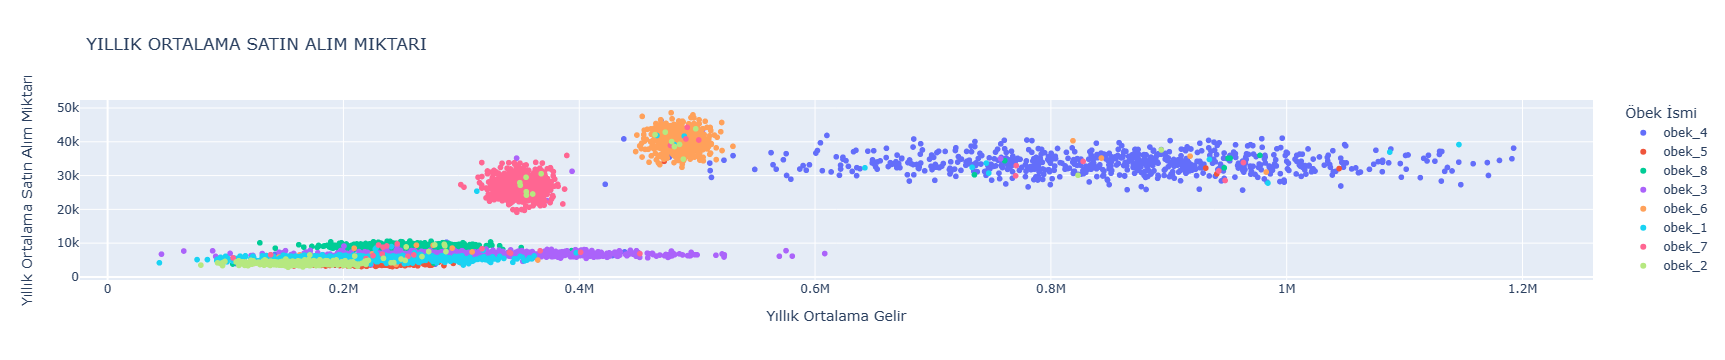

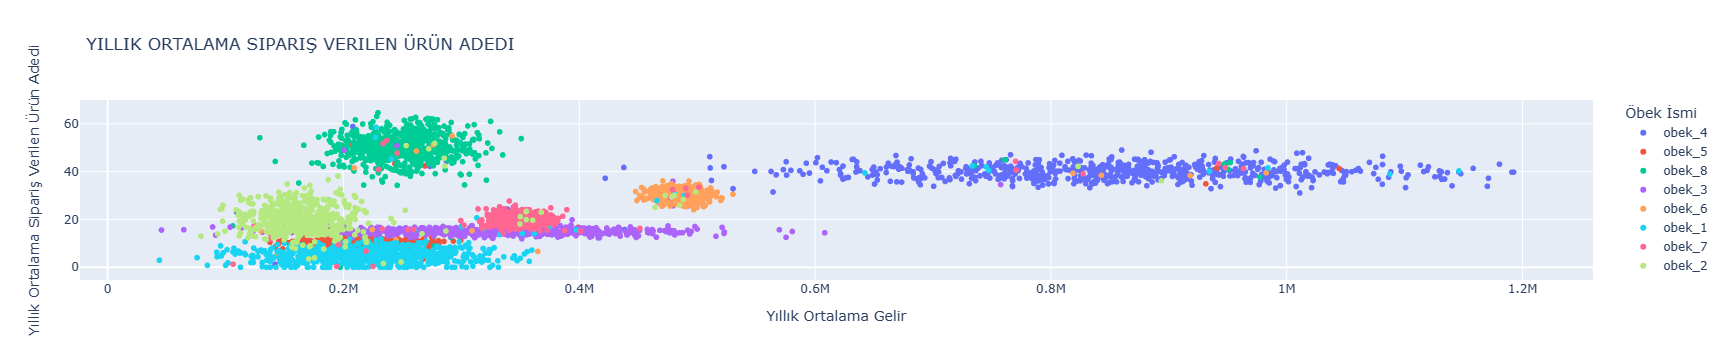

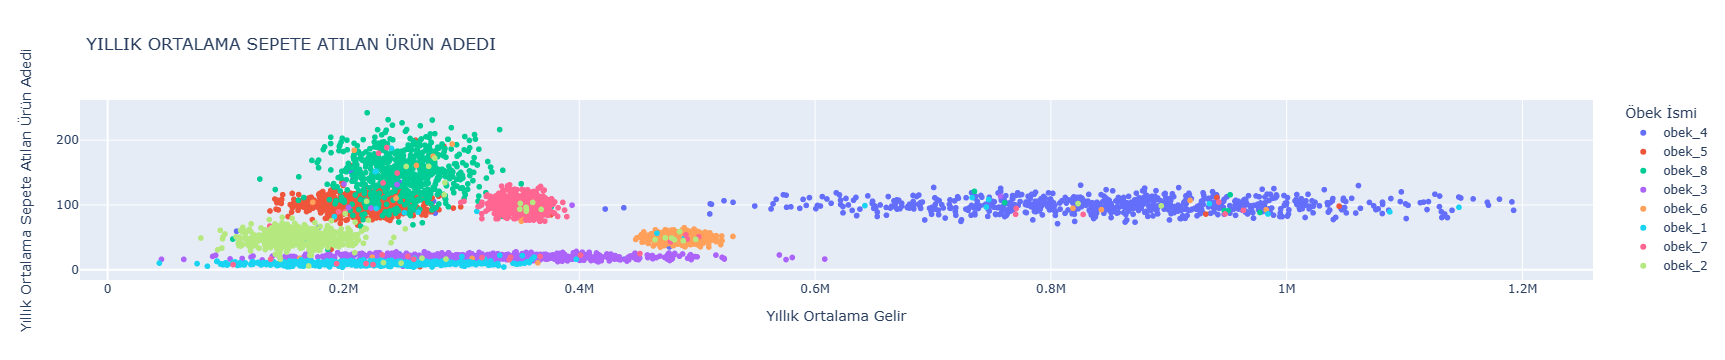

In [13]:
for degisken in surekli_degiskenler[1:]:
    fig = px.scatter(train, x='Yıllık Ortalama Gelir', y=degisken, color='Öbek İsmi', title=degisken.upper())
    fig.show()

<a id="1.7"></a>
## <b>1.7 <span style='color:#80055D'>|</span>Korelasyon📍</b>

Yıllık ortalama satın alım ile gelir arasında yüksek bir korelasyon var. Bu beklediğim bir şeydir. Sepete atılan ürün ile sipariş verilen ürün arasında da pozitif bir ilişki olduğu gözleniyor.

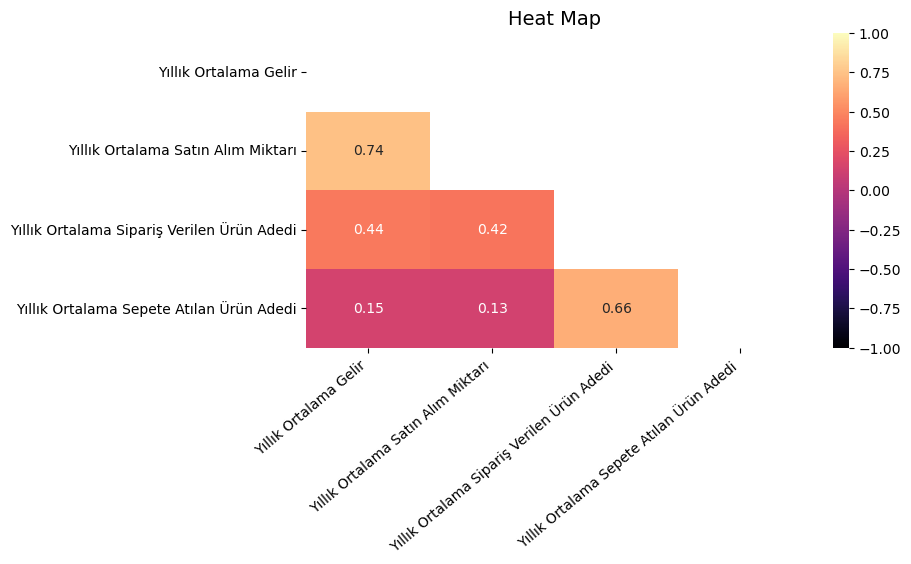

In [14]:
plt.style.use('default')
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(df.corr(), annot=True, fmt='.2f',
            vmin=-1, vmax=1,
            ax=ax, cmap='magma', mask=mask)
plt.xticks(rotation=40, ha='right')
plt.yticks(rotation=0, va='center')
plt.title('Heat Map', size=14)
plt.subplots_adjust(bottom=0.25)
plt.show()

<a id="2"></a>
<h1 id="import" style="color:white;background:#191970;padding:8px;border-radius:8px"><img src="https://user-images.githubusercontent.com/88631980/236693041-badeab36-8da4-4c1b-8171-4de19da3455a.png" alt="BTK Akademi Logo" width="45"/> Veri Ön İşleme 🛠</h1>

## <b>2.0 <span style='color:#80055D'>|</span>İzlence</b>

1. **Veri küçük olduğu için varsayılan parametreler ile sınıflandırma modellerinin hızlı bir karşılaştırılması**
    + En iyi iki modelin ön işleme adımları gerçeklenmeden varsayılan parametreler ile sonuçları
    +            Random Forest              0.954579
    +            CatBoost                   0.954396
    
2. **Accuracy değerini yükseltmek için çeşitli ön işleme adımları ve tekrar model denemeleri ve en yüksek başarıma sahip iki modelin seçilmesi**
    + Aykırı değer temizliği
    + Kategori Gruplama
    + Standartlaştırma
    + Yeni kolon ekleme
    
3. **Seçilen iki modelin hiperparametre optimizasyonu**
    + Catboost
    + Random Forest

In [15]:
# modellere vermek icin obek isimlerini uygun formata getirme
df['Öbek İsmi'] = df['Öbek İsmi'].map({'obek_4': 0,'obek_8': 1,'obek_5': 2,'obek_3': 3,'obek_7': 4,'obek_1': 5,'obek_6': 6,'obek_2': 7})

<a id="2.1"></a>
## <b>2.1 <span style='color:#80055D'>|</span>Aykırı Değerler</b>
Özellikle yıllık ortalama gelirde çokça aykırılıklar mevcut. Bu değerler modelin genelleştirme yeteneğini azaltacağı için bu değerleri gidermek gerekir. Gerçek dünya senaryolarında aykırıları **medyana** eşitlemek -aykırı bulduğun değerleri getirip veri setinin tam ortasına koymak- daha çok tercih edilir. Fakat buradaki veri setinde aykırı değerleri, **alt ve üst sınırlara** eşitlemek accuracy için daha olumlu sonuç verdi.   

In [16]:
def outliers(data):
    numerical_columns = data.select_dtypes(include=np.number).columns.tolist()
    for col in numerical_columns:
        q1, q3 = np.percentile(data[col], [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - iqr * 1.5
        upper_bound = q3 + iqr * 1.5
        median = data[col].median()
        data.loc[data[col] < lower_bound, col] = lower_bound
        data.loc[data[col] > upper_bound, col] = upper_bound

outliers(df)
outliers(test)

<a id="2.2"></a>
## <b>2.2 <span style='color:#80055D'>|</span>Kategori Gruplama</b>

<b>*Yaş Grubu*</b> isimli değişkendeki sınıfların dağılımlarını incelediğimde belli yaşlardaki kişilerin aynı bölgelerde toplandığını farkettim. Yakaladığım bu patternden dolayı sınıfları aşağıdaki gibi gruplamayı tercih ettim. Bu şekilde sınıflar da daha dengeli bir hale gelmiş oldu.

In [17]:
def yas_kategoriye_gore_grupla(yas):
    if yas in ['41-50', '51-60', '>60']:
        return 'yasli'
    elif yas in ['31-40']:
        return 'orta'
    elif yas in ['18-30']:
        return 'genc'
df['Yaş Grubu'] = df['Yaş Grubu'].apply(yas_kategoriye_gore_grupla)
test['Yaş Grubu'] = test['Yaş Grubu'].apply(yas_kategoriye_gore_grupla)

<a id="2.3"></a>
## <b>2.3 <span style='color:#80055D'>|</span>Yeni Feature Ekleme</b>

Scatter plotları incelendiğimde **obek_8** ve **obek_4**'ün benzer özelliklere sahip olduğunu farkettim. İki öbekte çalışan -iş gücüne katkı sağlayan- dinamik insanlardan oluşuyor. Dolayısıyla **genc_calisan_nufus** isminde yeni bir kolon oluşturdum.

Bu yöntem modelin genelleştirme yeteneğini genel olarak artırır fakat bu veri seti özelinde aşırı bir etki görmediğim için karmaşıklığıda artırmamamak adına bu **yöntemi kullanmama** kararı aldım.

In [18]:
#df['genc_calisan_nufus'] = ((df['Yaş Grubu'] == 'orta') | (df['Yaş Grubu'] == 'genc') & (df['İstihdam Durumu'] != 'Emekli')).astype(int)
#test['genc_calisan_nufus'] = ((test['Yaş Grubu'] == 'orta') | (test['Yaş Grubu'] == 'genc') & (test['İstihdam Durumu'] != 'Emekli')).astype(int)

<a id="2.4"></a>
## <b>2.4 <span style='color:#80055D'>|</span>Standartlaştırma ve Bağımlı-Bağımsız Değişken Ayrımı</b>

Veriler normal dağılım göstermediği ve aykırlıklar içerdiğinden dolayı **RobustScaler** kullandım. **TargetEncoder** ile de kategorik değişkenleri anlamlı hale getirdim. Encode yöntemi olarak one-hot encoder kullandığımda kolon sayısı aşırı artıyordu daha farklı bir yöntem aradım ve TargetEncoder yönteminde karar kıldım. Bu yöntem, kategorik değişkenlerin hedef değişkene göre ortalama değerlerini alarak kategorikleri sayısal değerlere dönüştürüyor. Bu sayede kategorik değişkenlerin hedef değişken ile olan ilişkisi de korunmuş oluyor.

**Not:** TargetEncoder, veri setindeki dağılımın test setine yansımadığı durumlarda overfitting riski taşıdığından dolayı kullanılması çok önerilmez. (Bu veri seti için böyle bir sorun yok.)

In [19]:
cat_cols = ["Cinsiyet", "Yaş Grubu", "Medeni Durum", "Eğitim Düzeyi", "İstihdam Durumu", "Yaşadığı Şehir", "Eğitime Devam Etme Durumu", "En Çok İlgilendiği Ürün Grubu"]
encoder = ce.TargetEncoder(cols=cat_cols)
y = df["Öbek İsmi"]
df[cat_cols] = encoder.fit_transform(df[cat_cols], y)

numerical_features = ['Yıllık Ortalama Gelir', 'Yıllık Ortalama Satın Alım Miktarı', 'Yıllık Ortalama Sipariş Verilen Ürün Adedi', 'Yıllık Ortalama Sepete Atılan Ürün Adedi']
scaler = RobustScaler()

df_numeric = df[numerical_features]
df_scaled = scaler.fit_transform(df_numeric)
df_scaled = pd.DataFrame(df_scaled, columns=numerical_features)
df[numerical_features] = df_scaled

y = df['Öbek İsmi']                  
x = df.drop(['Öbek İsmi'], axis=1) 

test[cat_cols] = encoder.transform(test[cat_cols]) 
test[numerical_features] = scaler.transform(test[numerical_features])

<a id="3"></a>
<h1 id="import" style="color:white;background:#191970;padding:8px;border-radius:8px"><img src="https://user-images.githubusercontent.com/88631980/236693041-badeab36-8da4-4c1b-8171-4de19da3455a.png" alt="BTK Akademi Logo" width="45"/> Modeller ⚙️</h1>

<a id="3.1"></a>
## <b>3.1 <span style='color:#80055D'>|</span>Varsayılan Parametreler ile Deneme ve Model Seçimi</b>

En yüksek başarımı sağlan modeller **Catboost** ve **Random Forest** olduğu için bu modelleri optimize edeceğim.

In [20]:
models = [
    ('Support Vector Classifier', SVC()),
    ('Naive Bayes', GaussianNB()),
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()), 
    ('XGBoost', xgb.XGBClassifier()),
    ('LightGBM', lgb.LGBMClassifier()),
    ('CatBoost', cb.CatBoostClassifier(verbose=0)),
    ('AdaBoost', AdaBoostClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier())
]

results = []

for model_name, model in models:
    cv_results = cross_val_score(model, x, y, cv=5, n_jobs=-1)
    mean_accuracy = cv_results.mean()
    model.fit(x, y)
    
    results.append((model_name, mean_accuracy))

df_results = pd.DataFrame(results, columns=['Model', 'Cross-Validation Accuracy'])
df_results.sort_values('Cross-Validation Accuracy', ascending=False, inplace=True)

print(df_results.to_string(index=False))

                    Model  Cross-Validation Accuracy
                 CatBoost                   0.954945
            Random Forest                   0.954579
                 LightGBM                   0.953846
                  XGBoost                   0.953297
Support Vector Classifier                   0.949084
              Naive Bayes                   0.947070
        Gradient Boosting                   0.943223
                 AdaBoost                   0.919414
                      KNN                   0.903846
            Decision Tree                   0.895055


<a id="3.2"></a>
## <b>3.2 <span style='color:#80055D'>|</span>Hiperparametre Tuning 💹</b>

In [ ]:
# RANDOM FOREST
random_forest = RandomForestClassifier()
param_grid = {
    'n_estimators': [10, 50, 100, 200, 300],
    'max_depth': [1, 5, 10, 20, 30],
    'min_samples_split': [1, 2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_rf = GridSearchCV(random_forest, param_grid, cv=5, n_jobs=-1)
grid_search_rf.fit(x, y)

best_params_rf = grid_search_rf.best_params_

print('En iyi parametreler:', grid_search_rf.best_params_)
print(grid_search_rf.best_score_)

In [ ]:
# {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

In [ ]:
# CATBOOST
catboost = cb.CatBoostClassifier(verbose=0)
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3, 0.5],
    'depth': [1, 5, 10, 20, 30],
    'l2_leaf_reg': [1, 3, 5],
    'iterations': [100, 200, 300, 400]
}
grid_search_cat = GridSearchCV(catboost, param_grid, cv=5, n_jobs=-1)
grid_search_cat.fit(x, y)

best_params_cat = grid_search_cat.best_params_

print('En iyi parametreler:', grid_search_cat.best_params_)
print(grid_search_cat.best_score_)

In [ ]:
# {'depth': 10, 'iterations': 300, 'l2_leaf_reg': 3, 'learning_rate': 0.1}

<a id="3.3"></a>
## <b>3.3 <span style='color:#80055D'>|</span>En İyi Parametreler ile Tekrar Fit Et</b>

In [25]:
best_params_rf = {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
best_params_cat = {'depth': 10, 'iterations': 300, 'l2_leaf_reg': 3, 'learning_rate': 0.1}

rf_model = RandomForestClassifier(**best_params_rf)
cat_model = cb.CatBoostClassifier(**best_params_cat, verbose=0)

models = [('Random Forest', rf_model), ('CatBoost', cat_model)]

results = []

for model_name, model in models:
    cv_results = cross_val_score(model, x, y, cv=5,  n_jobs=-1)
    mean_accuracy = cv_results.mean()
    model.fit(x, y)
    results.append((model_name, mean_accuracy))
    
df_results = pd.DataFrame(results, columns=['Model', 'Cross-Validation Accuracy'])
df_results.sort_values('Cross-Validation Accuracy', ascending=False, inplace=True)

print(df_results.to_string(index=False))

        Model  Cross-Validation Accuracy
     CatBoost                   0.954945
Random Forest                   0.954762


In [26]:
best_model_name = df_results.iloc[0]['Model']
best_model = [model for model_name, model in models if model_name == best_model_name][0]
predictions = best_model.predict(test)
predictions

array([[3],
       [3],
       [7],
       ...,
       [4],
       [2],
       [6]], dtype=int64)

In [27]:
# map islemini geri cevir
obek_numaralari_to_isim = {
    0: 'obek_4',
    1: 'obek_8',
    2: 'obek_5',
    3: 'obek_3',
    4: 'obek_7',
    5: 'obek_1',
    6: 'obek_6',
    7: 'obek_2'
}
predicted_obek_isimleri = [obek_numaralari_to_isim[obek_numara] for obek_numara in predictions.flatten()]

In [28]:
submission = pd.DataFrame({'id': range(len(predictions)), 'Öbek İsmi': predicted_obek_isimleri})
submission.to_csv('submission.csv', index=False)
submission.shape

(2340, 2)

## Teşekkürler ✨
### Enes Fehmi Manan